In [ ]:
# Step 1: Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:

import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, GlobalAveragePooling2D, Reshape, Activation, Add
from tensorflow.keras.optimizers import Adam

# Function to preprocess images (resize and normalize)
def preprocess(image, input_shape):
    image = cv2.resize(image, (input_shape[1], input_shape[0]))
    image = image.astype(np.float32) / 255.0
    return image

def data_generator(image_paths, class_id_paths, batch_size, input_shape, num_classes):
    while True:
        for start in range(0, len(image_paths), batch_size):
            end = min(start + batch_size, len(image_paths))
            batch_images = []
            batch_targets = []
            for i in range(start, end):
                # Load and preprocess the image
                image = cv2.imread(image_paths[i])
                image = preprocess(image, input_shape)
                batch_images.append(image)

                # Load and preprocess the class ID image
                class_id_image = cv2.imread(class_id_paths[i], cv2.IMREAD_GRAYSCALE)
                class_id_image = cv2.resize(class_id_image, (input_shape[1], input_shape[0]))

                # Ensure class IDs are within the valid range
                class_id_image[class_id_image >= num_classes] = num_classes - 1

                batch_targets.append(class_id_image)

            batch_images = np.array(batch_images)
            batch_targets = np.array(batch_targets)

            yield batch_images, batch_targets

# Data directories
original_image_dir = r"/content/drive/My Drive/joke/images"
class_id_image_dir = r"/content/drive/My Drive/joke/classlabels"

# Get list of file names
original_image_files = os.listdir(original_image_dir)
class_id_image_files = os.listdir(class_id_image_dir)

# Count the number of files in each directory
num_original_images = len(original_image_files)
num_class_id_images = len(class_id_image_files)

print(f"Number of original images: {num_original_images}")
print(f"Number of class ID images: {num_class_id_images}")

# Sort file names
original_image_files.sort()
class_id_image_files.sort()

# Check if the number of files match
if len(original_image_files) != len(class_id_image_files):
    raise ValueError("Number of files in directories do not match!")

# Create full paths for images
original_image_paths = [os.path.join(original_image_dir, fname) for fname in original_image_files]
class_id_image_paths = [os.path.join(class_id_image_dir, fname) for fname in class_id_image_files]

# Filter out missing images
valid_original_images = []
valid_class_id_images = []

for original_img_path, class_id_img_path in zip(original_image_paths, class_id_image_paths):
    if os.path.exists(original_img_path) and os.path.exists(class_id_img_path):
        valid_original_images.append(original_img_path)
        valid_class_id_images.append(class_id_img_path)
    else:
        print(f"Missing image file: {original_img_path} or {class_id_img_path}")

# Split the data into training and validation sets
train_orig_images, val_orig_images, train_class_id_images, val_class_id_images = train_test_split(
    valid_original_images, valid_class_id_images, test_size=0.1, random_state=42
)

# Define batch size
batch_size = 4
num_classes = 26  # Adjust this according to your specific number of classes
input_shape = (512, 512, 3)  # Example input shape, adjust as necessary

# Create data generators
train_gen = data_generator(train_orig_images, train_class_id_images, batch_size, input_shape, num_classes)
val_gen = data_generator(val_orig_images, val_class_id_images, batch_size, input_shape, num_classes)


Number of original images: 2928
Number of class ID images: 2928


In [ ]:
from keras.models import Model
from keras.layers import Input, Conv2D
from keras.optimizers import Adam

# Define input dimensions
input_height = 512
input_width = 512
input_channels = 3

# Define number of classes
num_classes = 26

# Define input tensor
input_tensor = Input(shape=(input_height, input_width, input_channels))

# Example convolutional layers
x = Conv2D(64, (3, 3), activation='relu', padding='same')(input_tensor)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)

# Final Conv2D layer for segmentation
x = Conv2D(num_classes, (1, 1), activation='softmax', name='output_layer')(x)

# Construct the model
model = Model(inputs=input_tensor, outputs=x)


In [ ]:
# Define the loss functions for each output
losses = {
    'output_layer': 'sparse_categorical_crossentropy'
}

# Compile the model
model.compile(optimizer=Adam(), loss=losses, metrics=['accuracy'])


In [ ]:
history = model.fit(
    train_gen,
    validation_data=val_gen,
    steps_per_epoch=len(train_orig_images) // batch_size,
    validation_steps=len(val_orig_images) // batch_size,
    epochs=2
)


Epoch 1/2
392/658 [================>.............] - ETA: 40:38 - loss: 1.7847 - accuracy: 0.5184

In [ ]:
history

1/1 [==============================] - 5s 5s/step


<ipython-input-6-25c60e94c758>:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('hsv', num_classes)


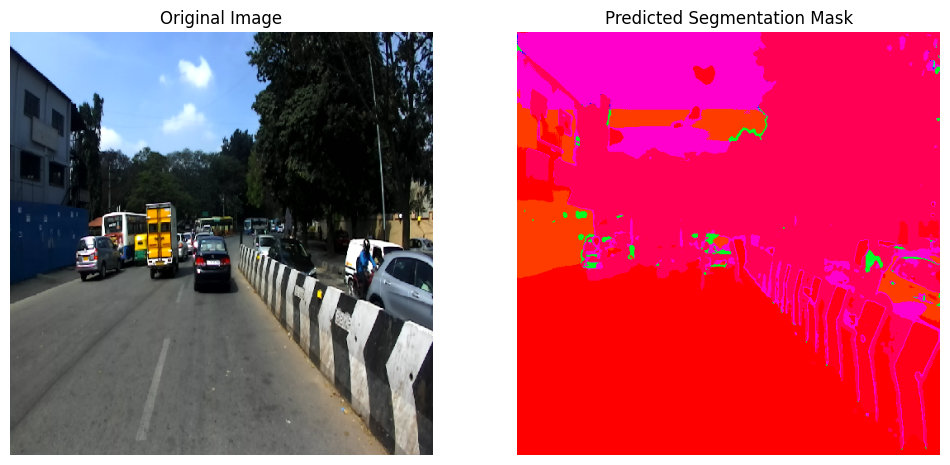

In [ ]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
import matplotlib.pyplot as plt

# Function to preprocess the input image
def preprocess_input_image(image_path, target_size=(512, 512)):
    img = load_img(image_path, target_size=target_size)
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    img = img / 255.0  # Normalize the image to [0, 1] range
    return img

# Function to map class labels to colors
def label_to_color(label, num_classes):
    colors = plt.cm.get_cmap('hsv', num_classes)
    color_image = colors(label)
    return (color_image[:, :, :3] * 255).astype(np.uint8)  # Convert to uint8 for visualization

# Specify the path to your image in Google Drive
image_path = '/content/drive/My Drive/joke/images/000986_leftImg8bit.png'  # Update this path

# Load and preprocess the input image
input_image = preprocess_input_image(image_path)

# Make a prediction
predicted_mask = model.predict(input_image)

# Remove batch dimension and convert to class labels
predicted_mask = np.squeeze(predicted_mask, axis=0)
predicted_class = np.argmax(predicted_mask, axis=-1)

# Map the class labels to colors
num_classes = 26  # Number of classes (update if different)
colored_mask = label_to_color(predicted_class, num_classes)

# Display the original image and the prediction
original_image = load_img(image_path, target_size=(512, 512))
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(original_image)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Predicted Segmentation Mask")
plt.imshow(colored_mask)
plt.axis('off')

plt.show()


1/1 [==============================] - 0s 29ms/step


<ipython-input-15-98c8a0667279>:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('hsv', num_classes)


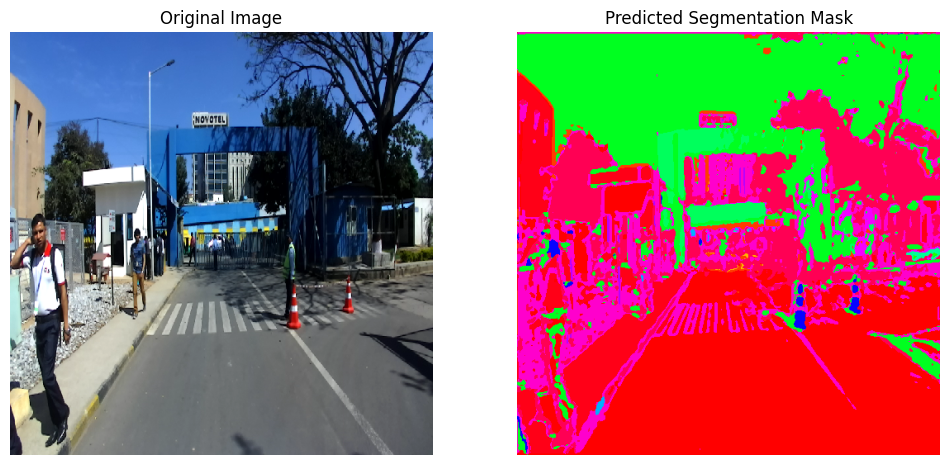

In [ ]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
import matplotlib.pyplot as plt

# Function to preprocess the input image
def preprocess_input_image(image_path, target_size=(512, 512)):
    img = load_img(image_path, target_size=target_size)
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    img = img / 255.0  # Normalize the image to [0, 1] range
    return img

# Function to map class labels to colors
def label_to_color(label, num_classes):
    colors = plt.cm.get_cmap('hsv', num_classes)
    color_image = colors(label)
    return (color_image[:, :, :3] * 255).astype(np.uint8)  # Convert to uint8 for visualization

# Specify the path to your image in Google Drive
image_path = '/content/drive/My Drive/joke/images/001558_leftImg8bit.png'  # Update this path

# Load and preprocess the input image
input_image = preprocess_input_image(image_path)

# Make a prediction
predicted_mask = model.predict(input_image)

# Remove batch dimension and convert to class labels
predicted_mask = np.squeeze(predicted_mask, axis=0)
predicted_class = np.argmax(predicted_mask, axis=-1)

# Map the class labels to colors
num_classes = 26  # Number of classes (update if different)
colored_mask = label_to_color(predicted_class, num_classes)

# Display the original image and the prediction
original_image = load_img(image_path, target_size=(512, 512))
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(original_image)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Predicted Segmentation Mask")
plt.imshow(colored_mask)
plt.axis('off')

plt.show()


1/1 [==============================] - 0s 27ms/step


<ipython-input-16-9f10b7d1f008>:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('hsv', num_classes)


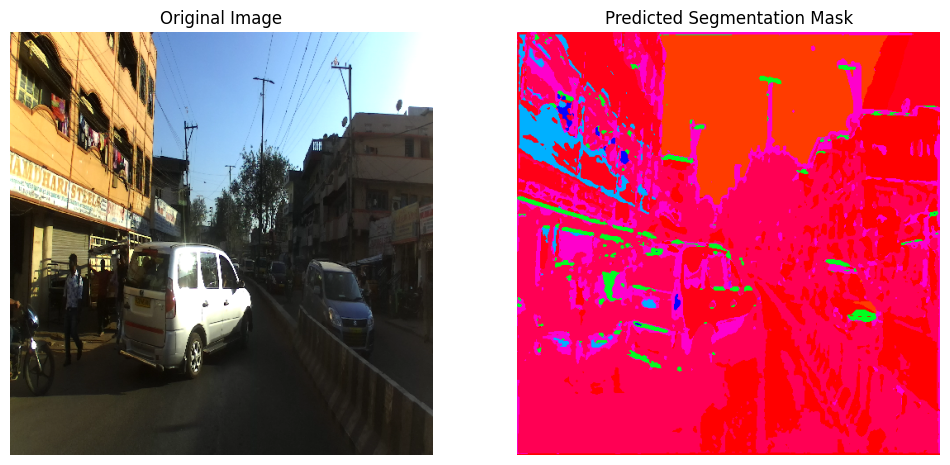

In [ ]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
import matplotlib.pyplot as plt

# Function to preprocess the input image
def preprocess_input_image(image_path, target_size=(512, 512)):
    img = load_img(image_path, target_size=target_size)
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    img = img / 255.0  # Normalize the image to [0, 1] range
    return img

# Function to map class labels to colors
def label_to_color(label, num_classes):
    colors = plt.cm.get_cmap('hsv', num_classes)
    color_image = colors(label)
    return (color_image[:, :, :3] * 255).astype(np.uint8)  # Convert to uint8 for visualization

# Specify the path to your image in Google Drive
image_path = '/content/drive/My Drive/joke/images/002185_leftImg8bit.png'  # Update this path

# Load and preprocess the input image
input_image = preprocess_input_image(image_path)

# Make a prediction
predicted_mask = model.predict(input_image)

# Remove batch dimension and convert to class labels
predicted_mask = np.squeeze(predicted_mask, axis=0)
predicted_class = np.argmax(predicted_mask, axis=-1)

# Map the class labels to colors
num_classes = 26  # Number of classes (update if different)
colored_mask = label_to_color(predicted_class, num_classes)

# Display the original image and the prediction
original_image = load_img(image_path, target_size=(512, 512))
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(original_image)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Predicted Segmentation Mask")
plt.imshow(colored_mask)
plt.axis('off')

plt.show()


1/1 [==============================] - 0s 29ms/step


<ipython-input-17-2e3b953b6188>:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('hsv', num_classes)


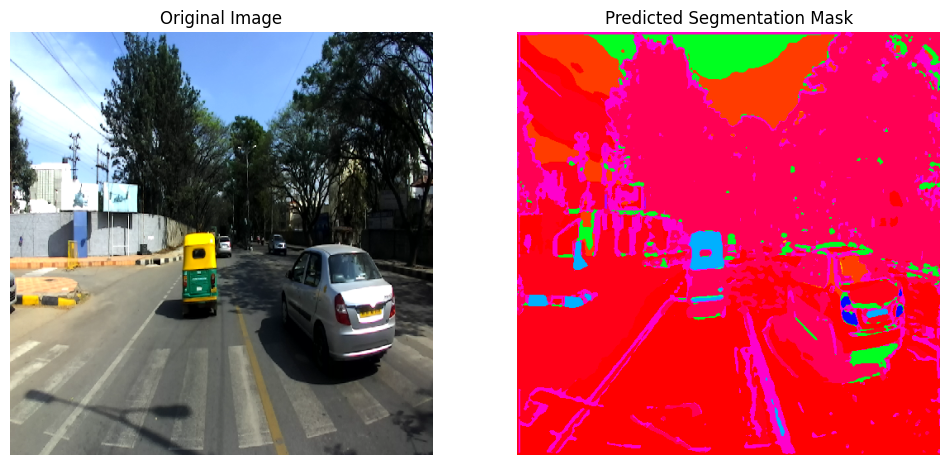

In [ ]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
import matplotlib.pyplot as plt

# Function to preprocess the input image
def preprocess_input_image(image_path, target_size=(512, 512)):
    img = load_img(image_path, target_size=target_size)
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    img = img / 255.0  # Normalize the image to [0, 1] range
    return img

# Function to map class labels to colors
def label_to_color(label, num_classes):
    colors = plt.cm.get_cmap('hsv', num_classes)
    color_image = colors(label)
    return (color_image[:, :, :3] * 255).astype(np.uint8)  # Convert to uint8 for visualization

# Specify the path to your image in Google Drive
image_path = '/content/drive/My Drive/joke/images/002967_leftImg8bit.png'  # Update this path

# Load and preprocess the input image
input_image = preprocess_input_image(image_path)

# Make a prediction
predicted_mask = model.predict(input_image)

# Remove batch dimension and convert to class labels
predicted_mask = np.squeeze(predicted_mask, axis=0)
predicted_class = np.argmax(predicted_mask, axis=-1)

# Map the class labels to colors
num_classes = 26  # Number of classes (update if different)
colored_mask = label_to_color(predicted_class, num_classes)

# Display the original image and the prediction
original_image = load_img(image_path, target_size=(512, 512))
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(original_image)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Predicted Segmentation Mask")
plt.imshow(colored_mask)
plt.axis('off')

plt.show()


1/1 [==============================] - 0s 30ms/step


<ipython-input-18-0d92728ddad3>:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('hsv', num_classes)


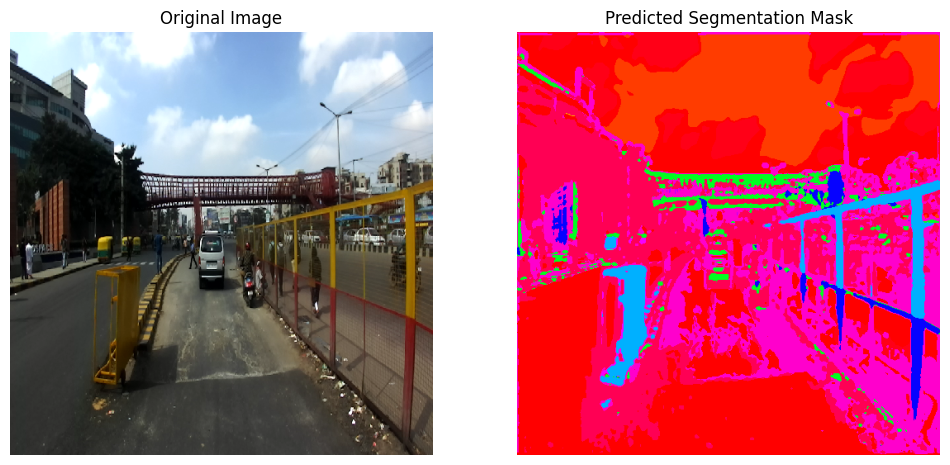

In [ ]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
import matplotlib.pyplot as plt

# Function to preprocess the input image
def preprocess_input_image(image_path, target_size=(512, 512)):
    img = load_img(image_path, target_size=target_size)
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    img = img / 255.0  # Normalize the image to [0, 1] range
    return img

# Function to map class labels to colors
def label_to_color(label, num_classes):
    colors = plt.cm.get_cmap('hsv', num_classes)
    color_image = colors(label)
    return (color_image[:, :, :3] * 255).astype(np.uint8)  # Convert to uint8 for visualization

# Specify the path to your image in Google Drive
image_path = '/content/drive/My Drive/joke/images/003184_leftImg8bit.png'  # Update this path

# Load and preprocess the input image
input_image = preprocess_input_image(image_path)

# Make a prediction
predicted_mask = model.predict(input_image)

# Remove batch dimension and convert to class labels
predicted_mask = np.squeeze(predicted_mask, axis=0)
predicted_class = np.argmax(predicted_mask, axis=-1)

# Map the class labels to colors
num_classes = 26  # Number of classes (update if different)
colored_mask = label_to_color(predicted_class, num_classes)

# Display the original image and the prediction
original_image = load_img(image_path, target_size=(512, 512))
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(original_image)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Predicted Segmentation Mask")
plt.imshow(colored_mask)
plt.axis('off')

plt.show()


In [ ]:
import os

# Define the path to save the model in your Google Drive
model_save_path = '/content/drive/My Drive/semantic_seg_model/'
os.makedirs(model_save_path, exist_ok=True)


In [ ]:
model.save(os.path.join(model_save_path, 'my_model.h5'))

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
